# Child Mind Institute — Problematic Internet Use
* In this challenge, the value of sii (target) is unknown for 1224 rows of train.csv file.
* A KNNImputer is used for handling features and missing values
* LGBMRegressor is used to predict the value of the sii column (presumably a target variable) based on the provided features in the dataset.

In [100]:
import numpy as np
import pandas as pd

#....................................................
import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None
!ls ../input/*

data_dictionary.csv    series_test.parquet   test.csv
sample_submission.csv  series_train.parquet  train.csv


In [101]:
train_data = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/train.csv', index_col='id')
test_data = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/test.csv', index_col='id')

train_data.shape, test_data.shape

((3960, 81), (20, 58))

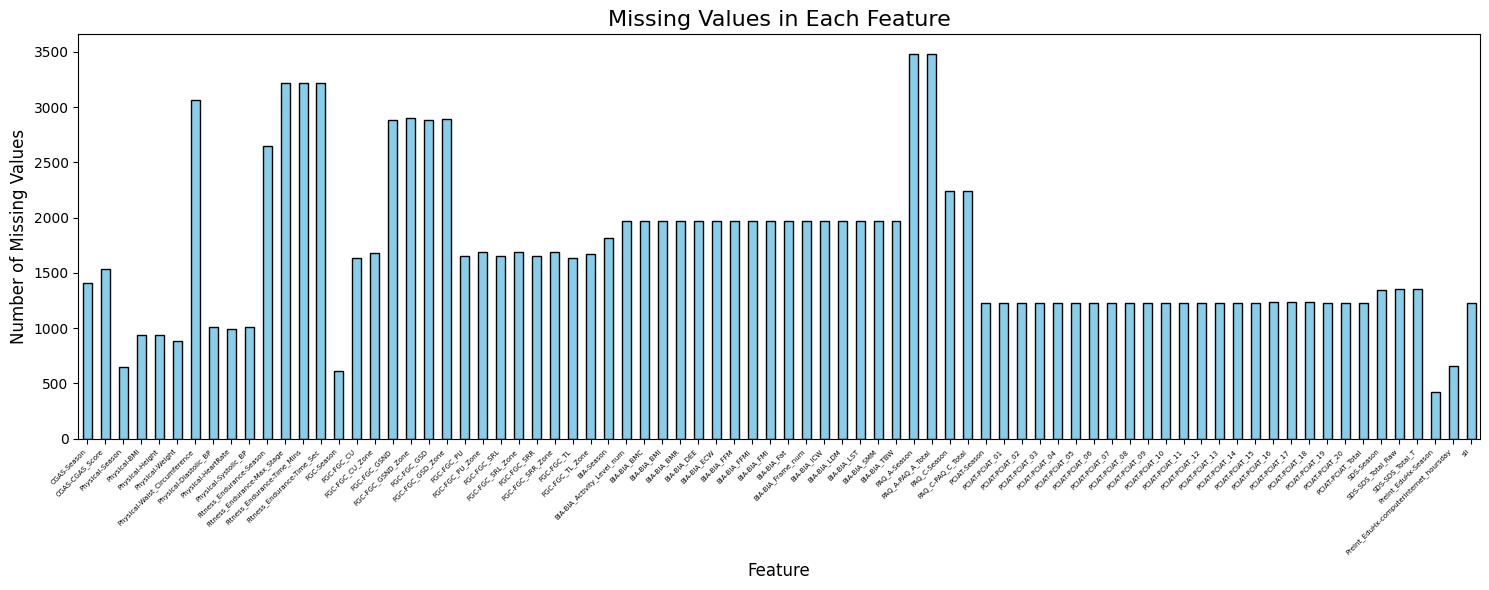

In [102]:
 import pandas as pd
 import matplotlib.pyplot as plt
 missing_values = train_data.isnull().sum()
 missing_values = missing_values[missing_values > 0]
 plt.figure(figsize=(15, 6))
 missing_values.plot(kind='bar', color='skyblue', edgecolor='black')
 plt.title('Missing Values in Each Feature', fontsize=16)
 plt.xlabel('Feature', fontsize=12)
 plt.ylabel('Number of Missing Values', fontsize=12)
 plt.xticks(rotation=45, ha='right', fontsize=5)
 plt.tight_layout()
 plt.show()

**Impute missing values in the 'sii' column using a LightGBM regression model.**

In [103]:
from sklearn.impute import KNNImputer
from lightgbm import LGBMRegressor

def filling_sii(data):
    # Filling missing data
    num_imputer = KNNImputer(n_neighbors=2, weights="uniform")
    
    features = data.columns.tolist()
        
    num_features = [f for f in features if data[f].dtype == 'float' or f == 'Basic_Demos-Age']
    impute_features = [f for f in num_features if f != 'sii']
    
    num_imputer.fit(data[impute_features])
    data[impute_features] = num_imputer.transform(data[impute_features])
    
    cat_features = [f for f in features if f not in num_features and f != 'sii']
    
    for cat in cat_features:
        data[cat] = data[cat].fillna('unknown')
        data[cat] = data[cat].astype('category')

    # Data preparation
    train_sii = data[data['sii'].notna()].copy()
    test_sii = data[data['sii'].isnull()].copy()
    y_sii = train_sii['sii'].copy()
    X_sii = train_sii.drop('sii', axis=1).copy()
    test_X_sii = test_sii.drop('sii', axis=1).copy()

    # Modeling
    lgbm_params = {
        'learning_rate': 0.046,
        'max_depth': 12,
        'num_leaves': 478,
        'min_data_in_leaf': 13,
        'feature_fraction': 0.893,
        'bagging_fraction': 0.784,
        'bagging_freq': 4,
        'lambda_l1': 10,  
        'lambda_l2': 0.01  
    }
    
    model = LGBMRegressor(**lgbm_params, verbose=-1)
    model.fit(X_sii, y_sii)

    pred = model.predict(test_X_sii)

    # Data setting
    X_sii['sii'] = y_sii.copy()
    test_X_sii['sii'] = np.round(pred.copy())
    
    sii_impute = pd.concat([X_sii, test_X_sii], axis=0)
    sii_impute.sort_index(axis=0, inplace=True)
    
    return sii_impute['sii']

train_data['sii'] = filling_sii(train_data.copy())

In [104]:
train_col = train_data.columns.tolist()
test_col = test_data.columns.tolist()

features = test_col.copy()

In [105]:
main_df = pd.concat([train_data[features], test_data], axis=0)

In [106]:
num_features = [f for f in features if train_data[f].dtype == 'float' or f=='Basic_Demos-Age']
cat_features = [f for f in features if f not in num_features]

len(cat_features), len(num_features)

(11, 47)

**Handle missing values in both numeric and categorical features.**

In [107]:
def handling_nulls(df):
    imputer = KNNImputer(n_neighbors=2, weights="uniform")

    imputer.fit(df[num_features])
    df[num_features] = imputer.transform(df[num_features])

    for cat in cat_features:
        df[cat] = df[cat].fillna('unknown')
        df[cat] = df[cat].astype('category')

    return df

main_df = handling_nulls(main_df)

In [108]:
from sklearn.preprocessing import MinMaxScaler

df_code = pd.get_dummies(main_df, columns=cat_features)

scaler = MinMaxScaler()
df_code[num_features] = scaler.fit_transform(df_code[num_features])

# Time series

In [109]:
from tqdm import tqdm
from IPython.display import clear_output
from concurrent.futures import ThreadPoolExecutor
import os

In [110]:
# Process time series data by reading and summarizing statistics.
def process_file(filename, dirname):
    data = pd.read_parquet(os.path.join(dirname, filename, 'part-0.parquet'))
    data.drop('step', axis=1, inplace=True)
    return data.describe().values.reshape(-1), filename.split('=')[1]
# Load and aggregate time series data into a summary DataFrame.
def load_time_series(dirname) -> pd.DataFrame:
    ids = os.listdir(dirname)
    
    with ThreadPoolExecutor() as executor:
        results = list(tqdm(executor.map(lambda fname: process_file(fname, dirname), ids), total=len(ids)))
    stats, indexes = zip(*results)
    
    data = pd.DataFrame(stats, columns=[f"stat_{i}" for i in range(len(stats[0]))])
    data['id'] = indexes
    return data

train_ts = load_time_series('/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet')
test_ts = load_time_series('/kaggle/input/child-mind-institute-problematic-internet-use/series_test.parquet')

time_series_cols = train_ts.columns.tolist()
time_series_cols.remove('id')

100%|██████████| 2/2 [00:00<00:00,  7.16it/s]


In [111]:
df_main_ts = pd.concat([train_ts, test_ts], axis=0)

scaler = MinMaxScaler()
df_main_ts[time_series_cols] = scaler.fit_transform(df_main_ts[time_series_cols])

In [112]:
df_code = df_code.reset_index()

train_df = df_code[:3960].copy()
test_df = df_code[3960:].copy()

train_df.shape, test_df.shape

((3960, 99), (20, 99))

In [113]:
train_ts = df_main_ts[:996].copy()
test_ts = df_main_ts[996:].copy()

train_ts.shape, test_ts.shape

((996, 97), (2, 97))

In [114]:
main_train_data = pd.merge(train_df, train_ts, how='left', on='id')
main_test_data = pd.merge(test_df, test_ts, how='left', on='id')

for col in time_series_cols:
    
    main_train_data[col] = main_train_data[col].fillna(main_train_data[col].median())
    main_test_data[col] = main_test_data[col].fillna(main_test_data[col].median())

main_train_data.shape, main_test_data.shape

((3960, 195), (20, 195))

# Train LightGBM model

In [115]:
y = train_data['sii'].copy()
X = main_train_data.drop('id', axis=1)
XX = main_test_data.drop('id', axis=1)

In [116]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [117]:
lgbm_params = {  
    'learning_rate': 0.046,
    'max_depth': 12,
    'num_leaves': 478,
    'min_data_in_leaf': 13,
    'feature_fraction': 0.893,
    'bagging_fraction': 0.784,
    'bagging_freq': 4,
    'lambda_l1': 10,  
    'lambda_l2': 0.01  
}

model = LGBMRegressor(**lgbm_params, verbose=-1)

model.fit(X, y)

LGBMRegressor(bagging_fraction=0.784, bagging_freq=4, feature_fraction=0.893,
              lambda_l1=10, lambda_l2=0.01, learning_rate=0.046, max_depth=12,
              min_data_in_leaf=13, num_leaves=478, verbose=-1)

In [118]:
pred = model.predict(XX)

# Submission

In [119]:
sub = pd.DataFrame({'id': main_test_data['id'], 'sii': np.round(pred)})
sub.to_csv('submission.csv', index=False)

# Evaluation

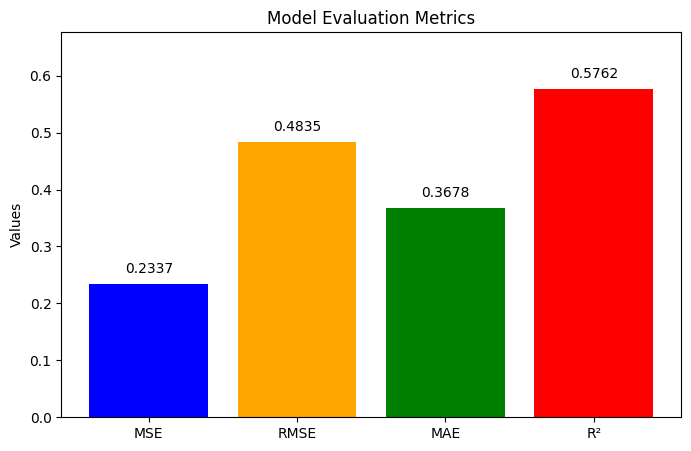

In [123]:
 from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
 import numpy as np
 pred = model.predict(X_test)
 mse = mean_squared_error(y_test, pred)
 rmse = np.sqrt(mse)
 mae = mean_absolute_error(y_test, pred)
 r2 = r2_score(y_test, pred)
 metrics = ['MSE', 'RMSE', 'MAE', 'R²']
 values = [mse, rmse, mae, r2]
 plt.figure(figsize=(8, 5))
 plt.bar(metrics, values, color=['blue', 'orange', 'green', 'red'])
 plt.title('Model Evaluation Metrics')
 plt.ylabel('Values')
 plt.ylim(0, max(values) + 0.1) 
for i, value in enumerate(values):
    plt.text(i, value + 0.02, f'{value:.4f}', ha='center')
 plt.show()